Na tarefa anterior se fixo unha pequena base de datos con caras. Neste caso se trata de facer unha aplicación de consola que cargue esa base de datos e tente identificar as caras presentes.

Á saída debera escribir os nomes das persoas que foi capaz de identificar e o número de persoas que non foi capaz de poñerlle nome.

In [1]:
import cv2
import csv
from matplotlib import pyplot as plt
import dlib
import numpy as np


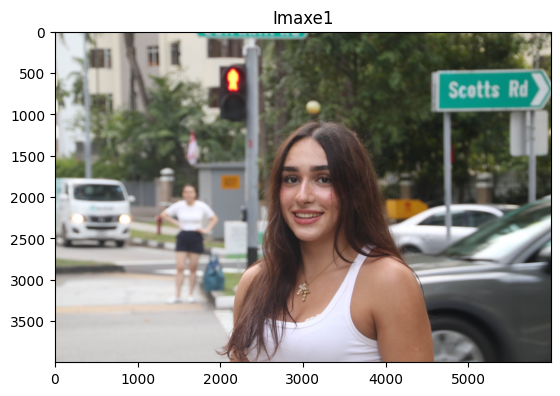

In [5]:
image = cv2.imread("../../docs/igmgm.jpg")
imaxe_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(imaxe_color)
plt.title('Imaxe1')
plt.show()

In [2]:
predictor_path ="../../docs/dlib/shape_predictor_5_face_landmarks.dat"
face_rec_model_path = "../../docs/dlib/dlib_face_recognition_resnet_model_v1.dat"


detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)
facerec = dlib.face_recognition_model_v1(face_rec_model_path)


In [11]:
vector_faces = []

with open("faces_names.csv", mode='r') as f:
    reader = csv.reader(f)
    for row in reader:
        nombre = row[0]
        descriptor = np.array(row[1:], dtype=float)
        vector_faces.append((descriptor, nombre))
print(f"Se han cargado {len(vector_faces)} rostros.")

Se han cargado 1 rostros.


In [6]:
face_names = []
dets = detector(imaxe_color, 1)
tolerancia = 0.6

for d in dets:
    shape = sp(imaxe_color, d)
    face_descriptor = np.array(facerec.compute_face_descriptor(imaxe_color, shape))
    
    # calculamos distancias y filtramos por tolerancia
    # match[0] es el descriptor guardado, match[1] es el nombre
    matches = [
        (np.linalg.norm(face_descriptor - match[0]), match[1]) 
        for match in vector_faces 
        if np.linalg.norm(face_descriptor - match[0]) <= tolerancia
    ]
        
    print(f"Matches encontrados: {matches}")

    if len(matches) == 0:
        face_names.append(((d.top(), d.right(), d.bottom(), d.left()), "NonSei"))
    else:
        carasOrdenadas = sorted(matches, key=lambda x: x[0]) 
        face_names.append(((d.top(), d.right(), d.bottom(), d.left()), carasOrdenadas[0][1]))
else:
    face_names.append(((d.top(), d.right(), d.bottom(), d.left()), "NonSei"))

Matches encontrados: []
Matches encontrados: [(np.float64(0.0), 'Nicki nicole')]


0.9176043243757857
[]
0.0
[(np.float64(0.0), 'Nicki nicole')]


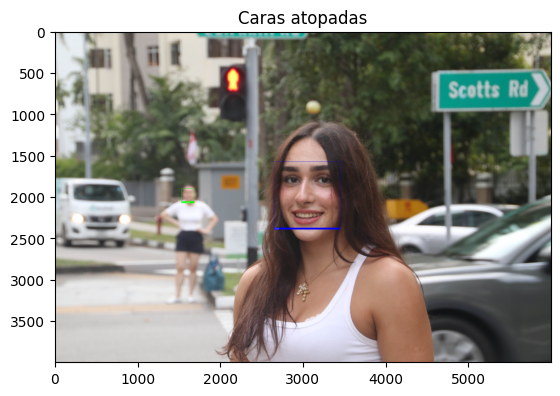

In [15]:
imaxeTodos = cv2.imread("../../docs/igmgm.jpg")
imaxeTodosColor = cv2.cvtColor(imaxeTodos, cv2.COLOR_BGR2RGB)

face_names = []

dets = detector(imaxeTodosColor, 1)
tolerancia = 0.6
for d in dets:

    shape = sp(imaxeTodosColor,d)
    face_descriptor = np.array(facerec.compute_face_descriptor(imaxeTodosColor, shape))
    print(np.linalg.norm(face_descriptor - vector_faces[0][0]))
    # See if the face is a match for the known face(s)
    matches = [(np.linalg.norm(face_descriptor - match[0]), match[1]) for match in vector_faces if np.linalg.norm(face_descriptor - match[0]) <= tolerancia]
    print(matches)
    if len(matches) == 0:
        face_names.append(((d.top(), d.right(), d.bottom(), d.left()),"NonSei"))
    else:
        carasOrdenadas = sorted(matches,key=lambda x: x[0]) 
        face_names.append(((d.top(), d.right(), d.bottom(), d.left()), carasOrdenadas[0][1]))
imaxeConMarcas = imaxeTodosColor.copy() 
for (top, right, bottom, left), name in face_names:
    # Scale back up face locations since the frame we detected in was scaled to 1/4 size

    color = (0, 255, 0)
    if name=="NonSei":
        color = (0, 0, 255)
    # Draw a box around the face
    cv2.rectangle(imaxeConMarcas, (left, top), (right, bottom), color, 2)

    # Draw a label with a name below the face
    cv2.rectangle(imaxeConMarcas, (left, bottom + 20), (right, bottom), color, cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(imaxeConMarcas, name, (left + 6, bottom + 15), font, 0.5, (255, 255, 255), 1)

plt.imshow(imaxeConMarcas)
plt.title('Caras atopadas')
plt.show()      